In [1]:
#Libraries

import pandas as pd
import numpy as np
import math
import os
import shutil
import cv2
import random
from glob import glob

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Convolution2D
from keras.layers import Flatten
from keras.layers import MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
root_path = 'C:\\Users\\shivambutoniya1793\\Desktop\\mlops\\COVID-CT-master\\Images-processed\\'
positive_case_path = os.path.join('C:\\Users\\shivambutoniya1793\\Desktop\\mlops\\COVID-CT-master\\Images-processed\\CT_COVID\\')
negative_case_path = os.path.join('C:\\Users\\shivambutoniya1793\\Desktop\\mlops\\COVID-CT-master\\Images-processed\\CT_NonCOVID\\')

In [3]:
positive_images = glob(os.path.join(positive_case_path,"*.png"))

negative_images = glob(os.path.join(negative_case_path,"*.png"))
negative_images.extend(glob(os.path.join(negative_case_path,"*.jpg")))

In [4]:
covid = {'class': 'CT_COVID',
         'path': positive_case_path,
         'images': positive_images}

non_covid = {'class': 'CT_NonCOVID',
             'path': negative_case_path,
             'images': negative_images}

In [5]:
total_positive_covid = len(positive_images)
total_negative_covid = len(negative_images)
print("Total Positive Cases Covid19 images: {}".format(total_positive_covid))
print("Total Negative Cases Covid19 images: {}".format(total_negative_covid))

Total Positive Cases Covid19 images: 349
Total Negative Cases Covid19 images: 397


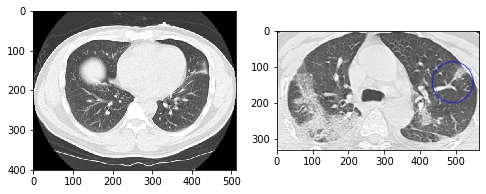

In [6]:
image_positive = cv2.imread(os.path.join(positive_images[1]))
image_negative = cv2.imread(os.path.join(negative_images[3]))

f = plt.figure(figsize=(8, 8))
f.add_subplot(1, 2, 1)
plt.imshow(image_negative)

f.add_subplot(1, 2, 2)
plt.imshow(image_positive)

In [7]:
print("Image COVID Shape {}".format(image_positive.shape))
print("Image Non COVID Shape {}".format(image_negative.shape))

Image COVID Shape (332, 566, 3)
Image Non COVID Shape (401, 512, 3)


In [8]:
# Create Train-Test Directory
subdirs  = ['C:\\Users\\shivambutoniya1793\\Desktop\\mlops\\COVID-CT-master\\Images-processed\\train\\', 
            'C:\\Users\\shivambutoniya1793\\Desktop\\mlops\\COVID-CT-master\\Images-processed\\test\\']
for subdir in subdirs:
    labeldirs = ['CT_COVID', 'CT_NonCOVID']
    for labldir in labeldirs:
        newdir = subdir + labldir
        os.makedirs(newdir, exist_ok=True)

In [9]:
# Copy Images to test set

random.seed(237)
test_ratio = 0.2

for cases in [covid, non_covid]:
    total_cases = len(cases['images']) 
    num_to_select = int(test_ratio * total_cases) #number of images to copy to test set
    
    print(cases['class'], num_to_select)
    
    list_of_random_files = random.sample(cases['images'], num_to_select) #random files selected

    for files in list_of_random_files:
        shutil.copy2(files, 'C:\\Users\\shivambutoniya1793\\Desktop\\mlops\\COVID-CT-master\\Images-processed\\test\\' 
                     + cases['class'])

CT_COVID 69
CT_NonCOVID 79


In [10]:
# Copy Images to train set
for cases in [covid, non_covid]:
    image_test_files = os.listdir('C:\\Users\\shivambutoniya1793\\Desktop\\mlops\\COVID-CT-master\\Images-processed\\test\\' 
                                  + cases['class']) # list test files 
    for images in cases['images']:
        if images.split('/')[-1] not in (image_test_files): #exclude test files from shutil.copy
            shutil.copy2(images, 'C:\\Users\\shivambutoniya1793\\Desktop\\mlops\\COVID-CT-master\\Images-processed\\train\\'
                         + cases['class'])

In [11]:
total_train_covid = len(os.listdir('C:\\Users\\shivambutoniya1793\\Desktop\\mlops\\COVID-CT-master\\Images-processed\\train\\CT_COVID'))
total_train_noncovid = len(os.listdir('C:\\Users\\shivambutoniya1793\\Desktop\\mlops\\COVID-CT-master\\Images-processed\\train\\CT_NonCOVID'))
total_test_covid = len(os.listdir('C:\\Users\\shivambutoniya1793\\Desktop\\mlops\\COVID-CT-master\\Images-processed\\test\\CT_COVID'))
total_test_noncovid = len(os.listdir('C:\\Users\\shivambutoniya1793\\Desktop\\mlops\\COVID-CT-master\\Images-processed\\test\\CT_NonCOVID'))

print("Train sets images COVID: {}".format(total_train_covid))
print("Train sets images Non COVID: {}".format(total_train_noncovid))
print("Test sets images COVID: {}".format(total_test_covid))
print("Test sets images Non COVID: {}".format(total_test_noncovid))

Train sets images COVID: 349
Train sets images Non COVID: 397
Test sets images COVID: 69
Test sets images Non COVID: 79


In [12]:
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

In [13]:
train_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our training data
test_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data

In [14]:
train_dir = os.path.join('C:\\Users\\shivambutoniya1793\\Desktop\\mlops\\COVID-CT-master\\Images-processed\\train')
test_dir = os.path.join('C:\\Users\\shivambutoniya1793\\Desktop\\mlops\\COVID-CT-master\\Images-processed\\test')


total_train = total_train_covid + total_train_noncovid
total_test = total_test_covid + total_test_noncovid

In [15]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')

Found 746 images belonging to 2 classes.


In [16]:
test_data_gen = test_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=test_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary')

Found 148 images belonging to 2 classes.


In [17]:
model = Sequential()

model.add(Convolution2D(filters=32,kernel_size=(3,3),padding='same',activation='relu',input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Convolution2D(filters=64,kernel_size=(3,3),padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Convolution2D(filters=128,kernel_size=(3,3),padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(units=512,activation='relu'))
model.add(Dense(units=1,activation='sigmoid'))

In [18]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 37, 37, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 18, 18, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 41472)            

In [19]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [20]:
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch = total_train // batch_size,
    epochs=epochs,
    validation_data = test_data_gen,
    validation_steps = total_test // batch_size
)

Epoch 1/15
5/5 [==============================] - 26s 5s/step - loss: 1.9310 - accuracy: 0.5049 - val_loss: 0.6975 - val_accuracy: 0.4531
Epoch 2/15
5/5 [==============================] - 23s 5s/step - loss: 0.6892 - accuracy: 0.5388 - val_loss: 0.6898 - val_accuracy: 0.5000
Epoch 3/15
5/5 [==============================] - 25s 5s/step - loss: 0.6561 - accuracy: 0.6036 - val_loss: 0.6677 - val_accuracy: 0.5625
Epoch 4/15
5/5 [==============================] - 21s 4s/step - loss: 0.6475 - accuracy: 0.5987 - val_loss: 0.6332 - val_accuracy: 0.6500
Epoch 5/15
5/5 [==============================] - 23s 5s/step - loss: 0.5879 - accuracy: 0.6634 - val_loss: 0.5997 - val_accuracy: 0.7031
Epoch 6/15
5/5 [==============================] - 21s 4s/step - loss: 0.5602 - accuracy: 0.7000 - val_loss: 0.5430 - val_accuracy: 0.7000
Epoch 7/15
5/5 [==============================] - 22s 4s/step - loss: 0.5249 - accuracy: 0.7346 - val_loss: 0.5114 - val_accuracy: 0.6719
Epoch 8/15
5/5 [==================

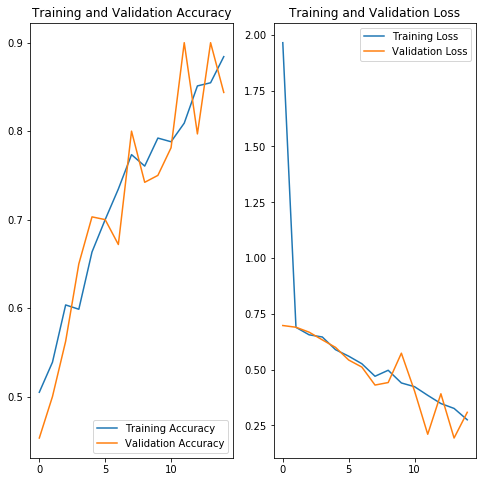

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()